# Getting Started with Melodia

Melodia is a library used for computing the differential geometry of the curves that describe the backbone of proteins. We designed it to be compatible with the Pandas (and BioPandas), BioPython and scikit-learn libraries. In this notebook, we will show some examples of its usage.

In [ ]:
# Uncomment for running in Google Colab
#!pip install melodia-py

In [1]:
import os 
import dill

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio.PDB import PDBParser, PDBIO

from sklearn.preprocessing import StandardScaler

In [2]:
# Import melodia library
import melodia_py as mel

## Creating a Pandas DataFrame object from a structure file

Melodia allows us to import a PDB file directly into a Pandas Dataframe. 

In [3]:
# Example with multiple chains
file_name = '2k5x.pdb'

In [4]:
# Example with multiple models
#file_name = '2lj5.pdb'

In [5]:
# Uncomment for running in Google Colab
#! curl -OJL https://github.com/rwmontalvao/melodia_py/raw/main/examples/2k5x.pdb
#! curl -OJL https://github.com/rwmontalvao/melodia_py/raw/main/examples/2lj5.pdb

In [6]:
# The geometry_from_structure_file function is used to open a traditional PDB file and convert it
# to a Pandas DataFrame with its differential geometry

dfi = mel.geometry_from_structure_file(file_name)

In [7]:
dfi

,id,model,code,chain,order,name,curvature,torsion,arc_length,writhing,phi,psi
0,0,0,2K5X,A,1,MET,1.171567,0.052793,8.114143,0.010657,0.000000,-162.771091
1,1,0,2K5X,A,2,GLU,1.171567,0.052793,7.744241,0.010657,-82.501456,55.322023
2,2,0,2K5X,A,3,LEU,0.516691,-0.049646,7.651813,0.010657,-104.765995,151.772894
3,3,0,2K5X,A,4,LYS,0.691968,-0.162003,7.697065,-0.044531,-91.287246,152.272637
4,4,0,2K5X,A,5,HIS,0.726271,-0.093555,8.377249,-0.064321,-78.677457,-25.081189
...,...,...,...,...,...,...,...,...,...,...,...,...
215,129,0,2K5X,B,130,ILE,0.374667,0.169407,8.658262,0.222338,-77.797020,-31.977884
216,130,0,2K5X,B,131,HIS,0.532056,-0.019662,8.427249,-0.003986,-92.569181,21.157166
217,131,0,2K5X,B,132,ARG,0.169288,-0.612796,8.394909,-0.103905,55.729215,55.176435
218,132,0,2K5X,B,133,GLY,0.279679,-0.081681,8.460548,-0.103905,104.961551,0.000000


## Model and Chain Selection

Due to the output data being in the Pandas format, we can use its notation for data processing. Thus, using the well-documented Pandas selection rules, model, and chain selection is trivial.

In [8]:
model = dfi['model'] == 0
chain = dfi['chain'] == 'A'

#dfo = dfi[model].copy() # Select only model
#dfo = dfi[chain].copy() # Select only chain
dfo = dfi[model & chain].copy() # Select both model and chain

In [9]:
dfo

,id,model,code,chain,order,name,curvature,torsion,arc_length,writhing,phi,psi
0,0,0,2K5X,A,1,MET,1.171567,0.052793,8.114143,0.010657,0.000000,-162.771091
1,1,0,2K5X,A,2,GLU,1.171567,0.052793,7.744241,0.010657,-82.501456,55.322023
2,2,0,2K5X,A,3,LEU,0.516691,-0.049646,7.651813,0.010657,-104.765995,151.772894
3,3,0,2K5X,A,4,LYS,0.691968,-0.162003,7.697065,-0.044531,-91.287246,152.272637
4,4,0,2K5X,A,5,HIS,0.726271,-0.093555,8.377249,-0.064321,-78.677457,-25.081189
...,...,...,...,...,...,...,...,...,...,...,...,...
81,81,0,2K5X,A,82,GLY,0.203739,-0.422102,8.542416,-0.040701,83.403801,-164.736189
82,82,0,2K5X,A,83,PHE,0.237940,-0.267700,8.600481,-0.077613,-84.411591,-155.711573
83,83,0,2K5X,A,84,LYS,0.339238,-0.213924,8.283604,-0.101704,-79.255597,173.443724
84,84,0,2K5X,A,85,GLN,0.486554,-0.228723,8.350652,-0.101704,-57.654642,0.000000


## Basic Plots

### A Ramachandran Plot

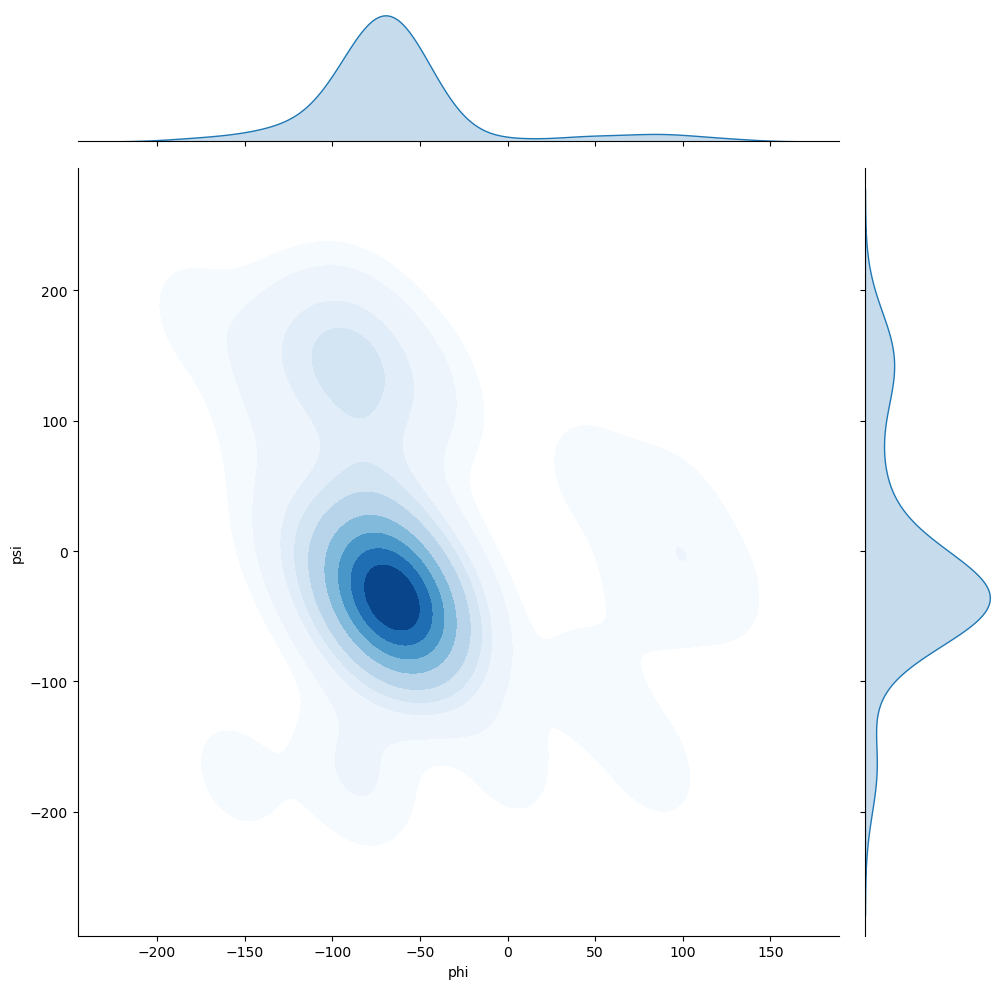

In [10]:
cmap = sns.color_palette('Blues', as_cmap=True)
sns.jointplot(x='phi', y='psi', data=dfo, kind='kde', cmap=cmap, height=10, fill=True);

### A Differential Geometry based Ramachandran-Like Plot

One of the valuable applications of Melodia is a Ramachandran-like plot for the curvature and torsion values. It shows the general geometric behaviour of the protein backbone. 

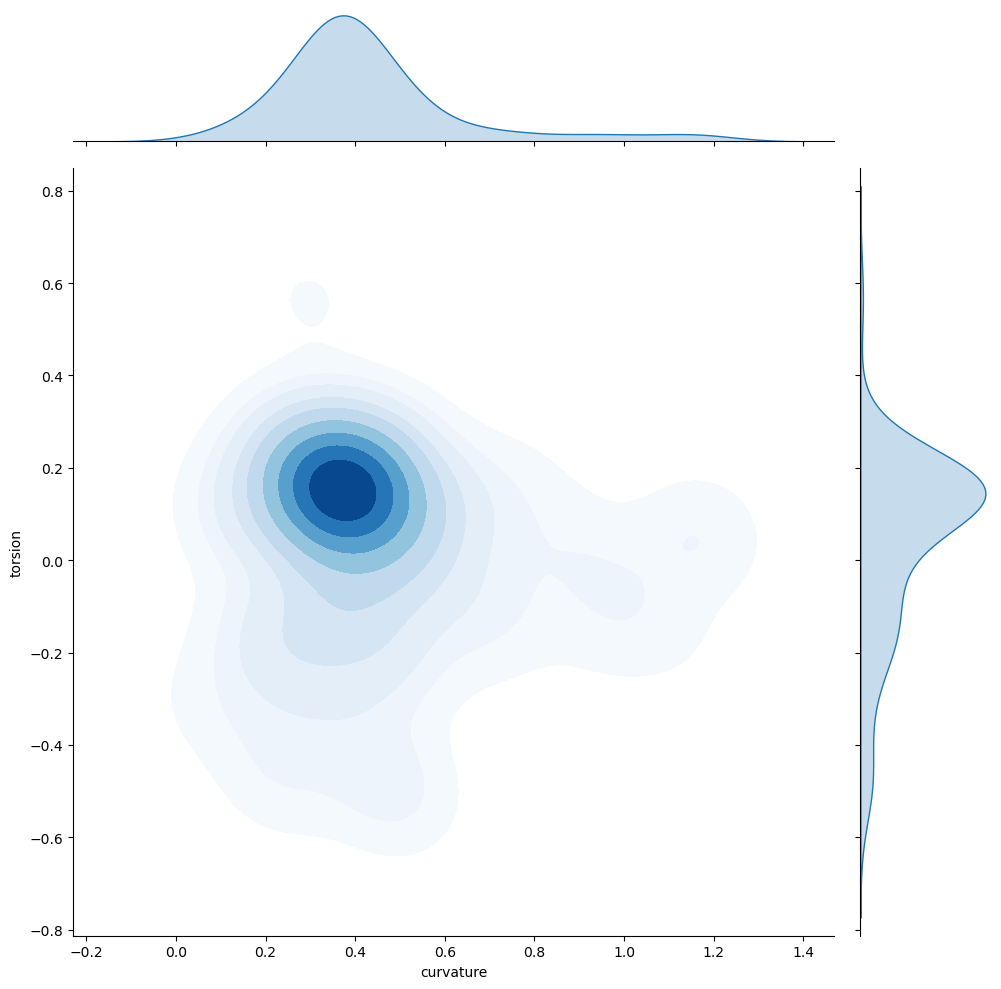

In [11]:
sns.jointplot(x='curvature', y='torsion', data=dfo, kind='kde', cmap=cmap, height=10, fill=True);

### Apply scikit-learn Standard Scaler to the Geometric Attributes

For Machine and Deep Learning applications, it is essential to standardize the differential geometry values, as curvature and torsion present different scales. One possible procedure is the scikit-learn StandardScaler function. Here, we want to select only the glycine residues and visualize their geometric distribution.

In [12]:
# Define the autoscaler from scikit-learn
autoscaler = StandardScaler()

# Define features for scaling
features = ['curvature', 'torsion', 'arc_length', 'writhing']

# Scale the DataFrame
dfsd = dfo.copy()
dfsd[features] = autoscaler.fit_transform(dfsd[features])

In [13]:
name = dfsd['name'] == 'GLY'
sel_name = dfsd[name].copy()
sel_name

,id,model,code,chain,order,name,curvature,torsion,arc_length,writhing,phi,psi
48,48,0,2K5X,A,49,GLY,-0.128180,0.977946,-0.540908,-0.245792,44.972589,-99.848320
58,58,0,2K5X,A,59,GLY,-0.631190,2.677661,-0.910662,0.165394,121.193572,-26.551811
65,65,0,2K5X,A,66,GLY,-0.477799,0.615834,1.185533,1.011539,-67.623018,-44.018333
78,78,0,2K5X,A,79,GLY,0.276979,-2.676076,-0.077266,-1.208328,95.086497,35.766671
81,81,0,2K5X,A,82,GLY,-1.087076,-2.323658,0.547101,-1.154254,83.403801,-164.736189
85,85,0,2K5X,A,86,GLY,0.278692,-1.344761,-0.583126,-1.640381,-66.647609,0.000000


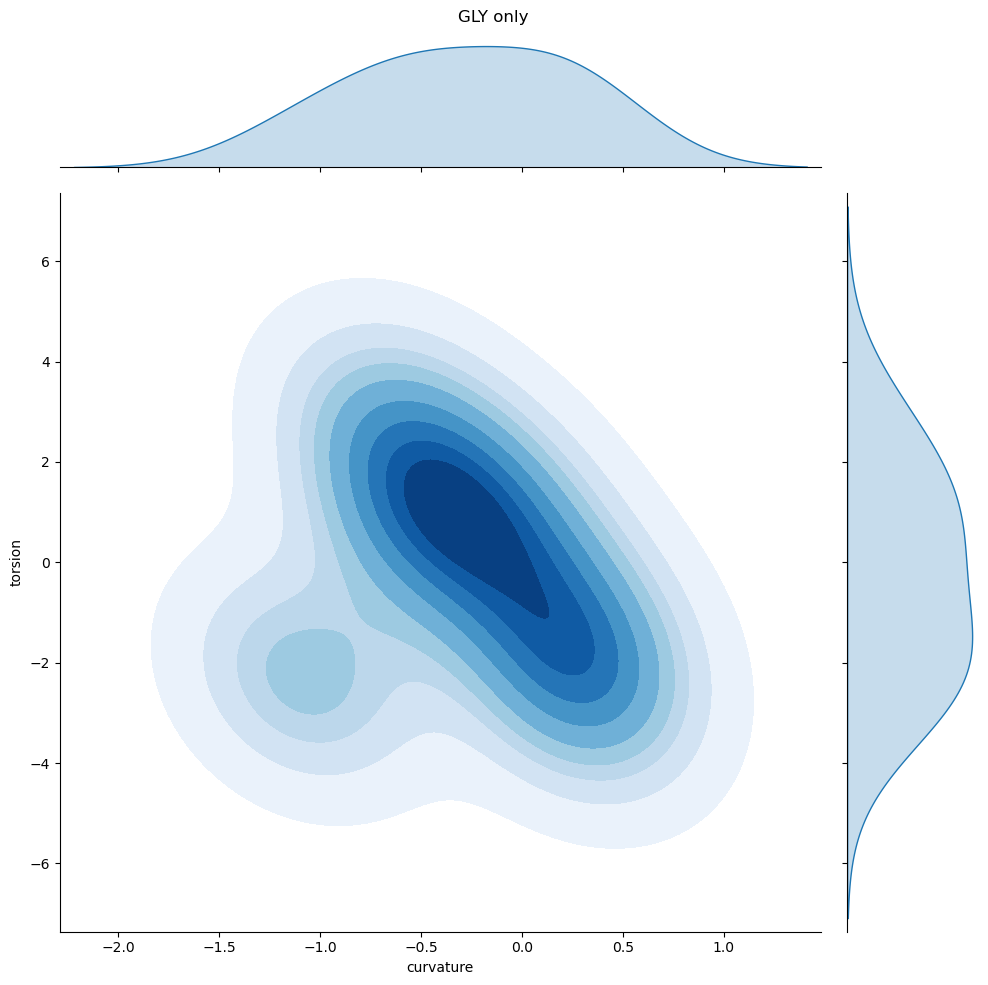

In [14]:
plot = sns.jointplot(x='curvature', y='torsion', data=sel_name, kind='kde', cmap=cmap, height=10, fill=True)
plot.fig.suptitle('GLY only')
plot.fig.subplots_adjust(top=0.95)

We can also select different residue types (GLY and GLU, for example), visualize their geometric distribution and compare their importance for the backbone shape.

In [15]:
# Select residues in a list of names
names = dfsd['name'].isin(['GLY', 'GLU'])
sel_names = dfsd[names].copy()
sel_names

,id,model,code,chain,order,name,curvature,torsion,arc_length,writhing,phi,psi
1,1,0,2K5X,A,2,GLU,3.586737,0.080297,-1.914499,-0.744994,-82.501456,55.322023
11,11,0,2K5X,A,12,GLU,0.790829,-0.173525,0.804693,-0.841186,-57.580338,-34.125995
13,13,0,2K5X,A,14,GLU,-0.371713,0.384923,2.005014,1.023282,-64.787354,-48.507163
29,29,0,2K5X,A,30,GLU,1.608337,0.646384,-1.841231,-0.251194,-40.783193,-43.117608
30,30,0,2K5X,A,31,GLU,-0.061435,0.664997,-0.235065,0.925236,-74.150571,-10.386134
31,31,0,2K5X,A,32,GLU,-0.584709,0.602751,0.305208,0.894054,-74.036575,-61.380129
40,40,0,2K5X,A,41,GLU,-0.635280,0.540318,-0.217487,0.721603,-69.737429,-46.407086
41,41,0,2K5X,A,42,GLU,-0.027440,0.597225,-0.286379,0.812652,-75.997483,-15.187741
44,44,0,2K5X,A,45,GLU,2.616839,-0.293022,-1.492463,-0.920844,81.051813,-29.644436
48,48,0,2K5X,A,49,GLY,-0.128180,0.977946,-0.540908,-0.245792,44.972589,-99.848320


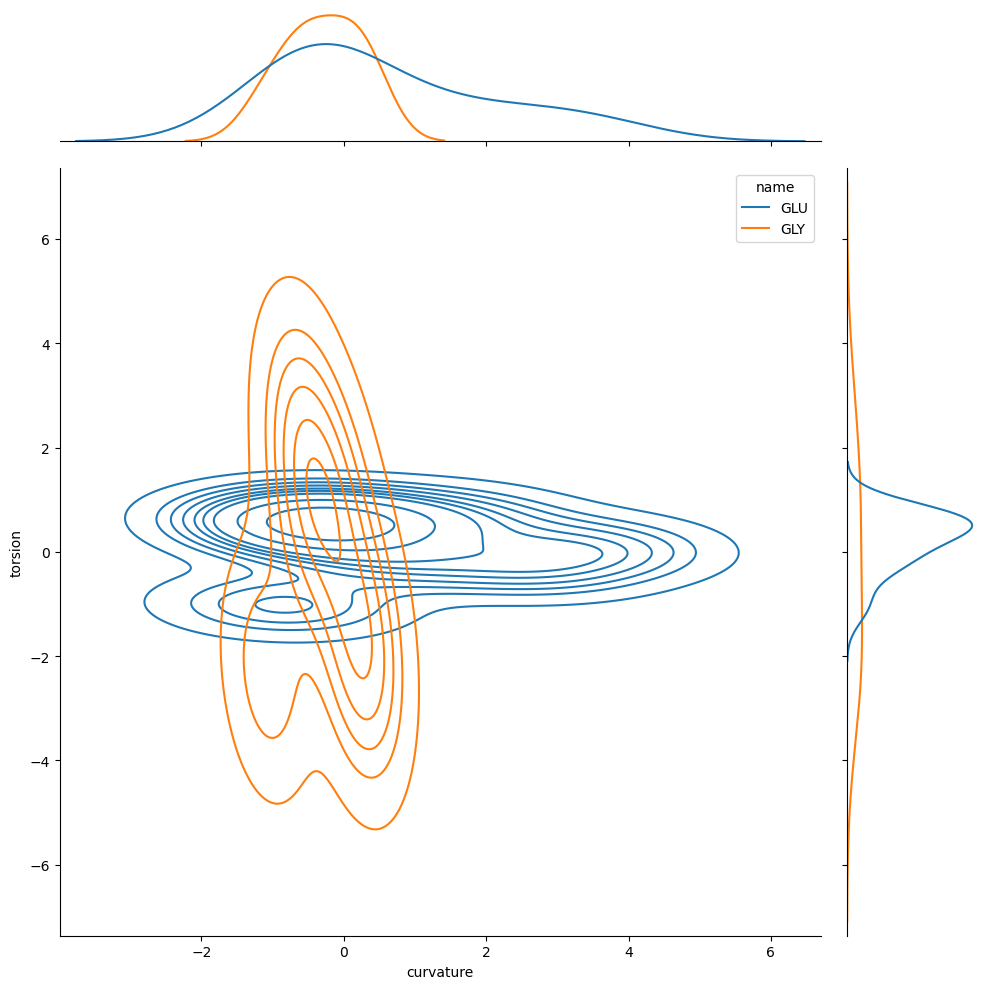

In [16]:
plot = sns.jointplot(x='curvature', y='torsion', data=sel_names, hue='name', kind='kde', height=10)

***

Through this plot, it is easy to observe the different behaviours of the backbone geometry on these residues. The GLU residue shows a more comprehensive curvature range and tight torsion range, while GLY is the opposite, showing a limited curvature range and ample torsion range. Thus, GLU tends to curve the backbone in a plane, and GLY allows backbone twists to escape the plane. For a more thorough explanation of this behaviour, **see figure 16 in**:

Pitt, W.R., Montalvão, R.W. & Blundell, T.L. Polyphony: superposition independent methods for ensemble-based drug discovery. *BMC Bioinformatics* **15**, 324 (2014). https://doi.org/10.1186/1471-2105-15-324

***

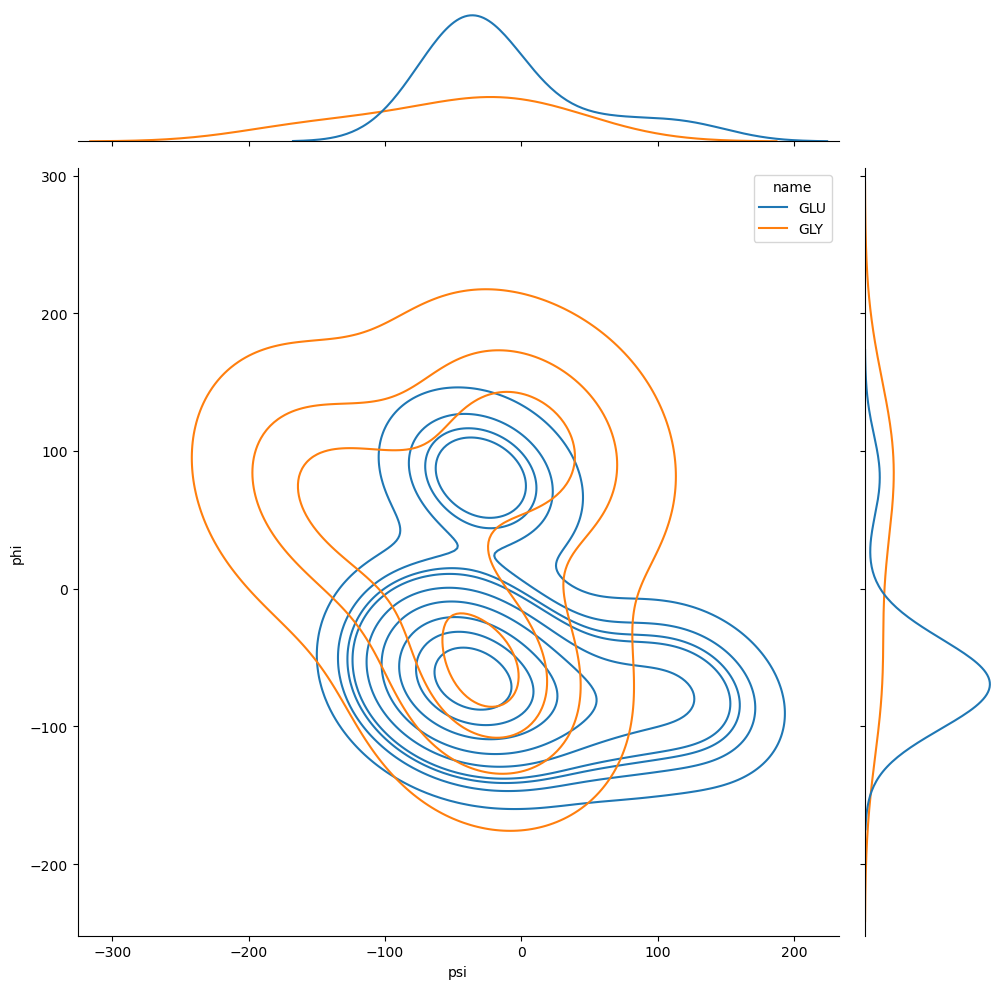

In [17]:
plot = sns.jointplot(x='psi', y='phi', data=sel_names, hue='name', kind='kde', height=10)

***
The same is not valid for a simple Ramachandran Plot for the same dataset. Despite showing some differences between GLU and GLY residues, it is unclear what the differences imply for the protein backbone plasticity. Once one becomes experienced with the differential geometry of 3D curves, it is easy to interpret the backbone geometry.
***

## Creating geometric data from a BioPython parsed structure

Sometimes, it is helpful to compute the geometric properties directly from a BioPython data structure.  Melodia provides functions that can parse the geometry from a parsed structure for those situations.

In [18]:
parser = PDBParser()
name, ext = os.path.splitext(file_name)
structure = parser.get_structure(name, file_name)

### Create a Panda DataFrame from the parser

In [19]:
dfbio = mel.geometry_from_structure(structure)
dfbio

,id,model,code,chain,order,name,curvature,torsion,arc_length,writhing,phi,psi
0,0,0,2K5X,A,1,MET,1.171567,0.052793,8.114143,0.010657,0.000000,-162.771091
1,1,0,2K5X,A,2,GLU,1.171567,0.052793,7.744241,0.010657,-82.501456,55.322023
2,2,0,2K5X,A,3,LEU,0.516691,-0.049646,7.651813,0.010657,-104.765995,151.772894
3,3,0,2K5X,A,4,LYS,0.691968,-0.162003,7.697065,-0.044531,-91.287246,152.272637
4,4,0,2K5X,A,5,HIS,0.726271,-0.093555,8.377249,-0.064321,-78.677457,-25.081189
...,...,...,...,...,...,...,...,...,...,...,...,...
215,129,0,2K5X,B,130,ILE,0.374667,0.169407,8.658262,0.222338,-77.797020,-31.977884
216,130,0,2K5X,B,131,HIS,0.532056,-0.019662,8.427249,-0.003986,-92.569181,21.157166
217,131,0,2K5X,B,132,ARG,0.169288,-0.612796,8.394909,-0.103905,55.729215,55.176435
218,132,0,2K5X,B,133,GLY,0.279679,-0.081681,8.460548,-0.103905,104.961551,0.000000


### Create a dictionary of attribute from the parser

Storing the geometric data in a flexible, lightweight structure is advantageous for general Python programming. Melodia provides a simple dictionary that stores a convenient data class. 

In [20]:
geo_dict = mel.geometry_dict_from_structure(structure)
geo_dict

{'0:A': <melodia_py.geometryparser.GeometryParser at 0x765a48e19300>,
 '0:B': <melodia_py.geometryparser.GeometryParser at 0x765a4a89c310>}

In [21]:
# Access format 'model:chain'
geo_dict['0:A'].residues[0]

ResidueGeometry(name='MET', chain='A', res_num=0, res_order=1, curvature=1.1715667454704115, torsion=np.float64(0.05279292619204095), arc_len=8.114142887215975, writhing=np.float64(0.010656569241575084), phi=0.0, psi=-162.77109080718967, res_ann={}, custom=0.0)

In [22]:
print(geo_dict['0:A'].residues[0].name)
print(geo_dict['0:A'].residues[0].curvature)
print(geo_dict['0:A'].residues[0].torsion)

MET
1.1715667454704115
0.05279292619204095


## Data Storage

The Geometric Data in a data frame can be stored using **Pandas** functions. Additionally, the data in a dictionary can be stored in a file (pickled) using the **Dill library** (https://github.com/uqfoundation/dill).

In [ ]:
dfbio.to_parquet('dfbio.parquet.gzip', compression='gzip')

In [ ]:
dfbio_loaded = pd.read_parquet('dfbio.parquet.gzip')
dfbio_loaded

In [ ]:
# Save dictionary to a file
with open('geo.dill', 'wb') as file:
    dill.dump(geo_dict, file)

In [ ]:
# Load dictionary from a file
with open('geo.dill', 'rb') as file:
    geo_dict_loaded = dill.load(file)

In [ ]:
geo_dict_loaded['0:A'].residues[0]

## Advanced Visualization

When using a BioPython structure object, Melodia can set its b-factor values as any geometric attribute. It permits us to visualize the value of the geometric descriptor as colours and radius project into the protein backbone.

We use the nglview widget for visualization (https://github.com/nglviewer/nglview).

In [ ]:
mel.bfactor_from_geo(structure=structure, attribute='curvature', geo=geo_dict)
mel.bfactor_from_geo(structure=structure, attribute='torsion', geo=geo_dict)

### View structure as a putty model

In [ ]:
mel.view_putty(structure[0], radius_scale=1.4, width=800, height=600)

### View structure as a cartoon

In [ ]:
mel.view_cartoon(structure[0], width=800, height=600)

### View structure as a tube model

In [ ]:
mel.view_tube(structure[0], width=800, height=600)

### Save the structure to a PDB file with the new bfactors



In [ ]:
io = PDBIO()
io.set_structure(structure)
io.save('out.pdb')

After loading the PDB file in PyMol, the following command will create the correct visualization for the differential geometry:

1. show cartoon
2. cartoon putty
3. unset cartoon_smooth_loops
4. unset cartoon_flat_sheets
5. spectrum b

![PyMolImage](out.png)

## Access the Propensity Table for a target residue

Lastly, Melodia includes **Environmentally Constrained Amino Acid Propensity Tables**. These tables, divided into six *φ/ψ* areas, indicate the propensity for a residue to be replaced by another in a specific conformation. It is a very advanced topic discussed in the following articles:


1. Rinaldo W. Montalvão, Richard E. Smith, Simon C. Lovell, Tom L. Blundell, CHORAL: a differential geometry approach to the prediction of the cores of protein structures, *Bioinformatics*, Volume 21, Issue 19, January 2005, Pages 3719–3725, https://doi.org/10.1093/bioinformatics/bti595

2. Deane CM, Blundell TL. CODA: a combined algorithm for predicting the structurally variable regions of protein models. *Protein Sci.* 2001 Mar;10(3):599-612. https://doi.org/10.1110/ps.37601

In [ ]:
ptable = mel.PropensityTable()

In [ ]:
phi = -82.0
psi =  55.0
ptable.get_score(target='F', residue='A', phi=phi, psi=psi)